In [2]:
""" 
We aim to solve the simplest game (contract is 1000 fixed), 10 players using regret minimization
Goal: get cfr running on known solution game, before shifting to dif. contracts

Using regret minimization mentioned here:
    yt vid - https://www.youtube.com/watch?v=Wa-fRIBGZZI
    associated github - https://github.com/IanSullivan/PokerCFR/blob/main/RockPaperScissors.py
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class RegretMinimization:
    def __init__(self, num_players, possible_actions, reward_function):
        self.reward_function = reward_function
        self.NUM_PLAYERS = num_players
        self.NUM_ACTIONS = len(possible_actions)

        self.possible_actions = np.arange(self.NUM_ACTIONS) # 0 to 101
        self.regret_sums = np.zeros(shape=(self.NUM_PLAYERS, self.NUM_ACTIONS))
        self.strategy_sums = np.zeros(shape=(self.NUM_PLAYERS, self.NUM_ACTIONS))

    # Gets strategy from regret sum
    def get_strategy(self, regret_sum):
        new_sum = np.clip(regret_sum, a_min=0, a_max=None)
        normalizing_sum = np.sum(new_sum)
        if normalizing_sum > 0:
            new_sum /= normalizing_sum
        else:
            new_sum = np.repeat(1/self.NUM_ACTIONS, self.NUM_ACTIONS)
        return new_sum
    
    # Only used at very end; finds the average strategy used throughout
    def get_average_strategy(self, strategy_sum):
        average_strategy = np.zeros(self.NUM_ACTIONS)
        normalizing_sum = sum(strategy_sum)
        for index, action in enumerate(self.possible_actions):
            if normalizing_sum > 0:
                average_strategy[index] = strategy_sum[index] / normalizing_sum
            else:
                average_strategy[index] = 1.0 / self.NUM_ACTIONS
        return np.round(average_strategy, decimals=3)
    
    def graph_average_strategies(self):
        colors = plt.cm.tab10(np.linspace(0, 1, self.NUM_PLAYERS))
        for p in range(self.NUM_PLAYERS):
            strategy = self.get_average_strategy(self.strategy_sums[p])
            sns.lineplot(strategy, color=colors[p])
        plt.show()

    def graph_strategies(self):
        colors = plt.cm.tab10(np.linspace(0, 1, self.NUM_PLAYERS))
        for p in range(self.NUM_PLAYERS):
            strategy = self.get_strategy(self.strategy_sums[p])
            sns.lineplot(strategy, color=colors[p])
        plt.show()


    def get_action(self, strategy):
        return np.random.choice(self.possible_actions, p=strategy)

    # Based on others' actions array, find my utility
    def get_reward(self, my_action, opponent_action):
        return self.reward_function(my_action, opponent_action)

    def train(self, iterations):
        for _ in range(iterations):
            # Get each players actions, update strategy sums
            actions = np.zeros(self.NUM_PLAYERS)
            for player in range(self.NUM_PLAYERS):
                strategy = self.get_strategy(self.regret_sums[player])
                self.strategy_sums[player] += strategy
                my_action = self.get_action(strategy)

                actions[player] = my_action

            # Get each players reward / regrets
            for player in range(self.NUM_PLAYERS):
                my_action = actions[player]
                others_actions = np.delete(actions, player)
                my_reward = self.get_reward(my_action, others_actions)

                for index, action in enumerate(self.possible_actions):
                    my_regret = self.get_reward(action, others_actions) - my_reward
                    self.regret_sums[player, index] += my_regret

In [3]:
# Setup polarized contract
numPlayers = 10
possible_actions = np.arange(1, 31, 1)

def polarizedContract(my_action, opponent_action):
    # changing contract to be 15 or 45, instead of 50
    contractVals = [25,75]
    totalReward = 0

    for contract in contractVals:
        lessTotal = np.sum(np.where(opponent_action < my_action, opponent_action, 0))
        countSame = np.count_nonzero(np.array(opponent_action) == my_action)

        remainingCash = contract - lessTotal
        reward = 0
        if my_action <= remainingCash:
            available_fill = remainingCash//my_action
            probChosen = min(1, 1/(1+countSame) * available_fill)
            reward = my_action * probChosen
        totalReward += reward
    return totalReward/len(contractVals)

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_82878/3120357774.py:17: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_fill = remainingCash//my_action


player 0 policy: [0.    0.    0.    0.    0.    0.836 0.029 0.003 0.103 0.026 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 1 policy: [0.    0.    0.    0.    0.    0.486 0.014 0.004 0.003 0.267 0.222 0.001
 0.001 0.    0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 2 policy: [0.    0.    0.    0.    0.    0.211 0.029 0.004 0.053 0.401 0.299 0.
 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 3 policy: [0.    0.    0.    0.    0.    0.615 0.012 0.004 0.003 0.243 0.112 0.009
 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 4 policy: [0.    0.    0.    0.    0.    0.892 0.026 0.004 0.031 0.041 0.005 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 5 policy:

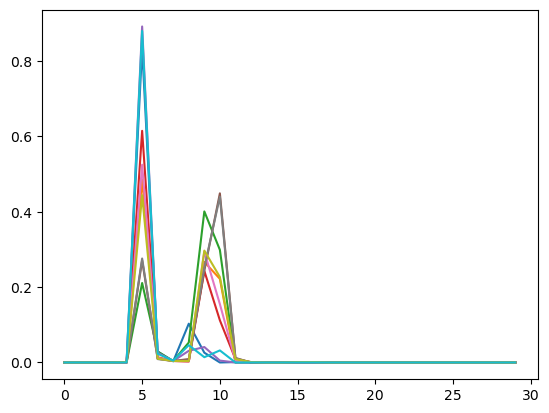

In [ ]:
# Run polarized contract
trainer = RegretMinimization(numPlayers, possible_actions, polarizedContract)
trainer.train(1000)

# for p in range(trainer.NUM_PLAYERS):
#     policy = trainer.get_average_strategy(trainer.strategy_sums[p])
#     print(f'player {p} policy:', policy)
trainer.graph_average_strategies()

In [4]:
# Setup normal dist. contract
numPlayers = 10
possible_actions = np.arange(1, 31, 1)

def uniformContract(my_action, opponent_action):
    # changing contract to be 15 or 45, instead of 50
    contractVals = np.arange(20, 41)
    totalReward = 0

    for contract in contractVals:
        lessTotal = np.sum(np.where(opponent_action < my_action, opponent_action, 0))
        countSame = np.count_nonzero(np.array(opponent_action) == my_action)

        remainingCash = contract - lessTotal
        reward = 0
        if my_action <= remainingCash:
            available_fill = remainingCash//my_action
            probChosen = min(1, 1/(1+countSame) * available_fill)
            reward = my_action * probChosen
        totalReward += reward
    return totalReward/len(contractVals)

In [5]:
# Run uniform
trainer = RegretMinimization(numPlayers, possible_actions, uniformContract)
trainer.train(1000)

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_97185/1884691589.py:17: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_fill = remainingCash//my_action


player 0 policy: [0.    0.    0.    0.936 0.054 0.004 0.002 0.001 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 1 policy: [0.    0.    0.    0.937 0.053 0.004 0.002 0.001 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 2 policy: [0.    0.    0.001 0.932 0.057 0.004 0.002 0.001 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 3 policy: [0.    0.    0.    0.937 0.052 0.005 0.002 0.002 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 4 policy: [0.    0.    0.    0.929 0.06  0.004 0.002 0.001 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 5 policy: [0.    0

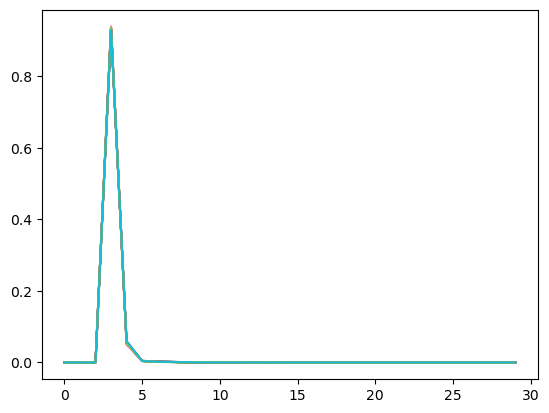

In [6]:
for p in range(trainer.NUM_PLAYERS):
    policy = trainer.get_average_strategy(trainer.strategy_sums[p])
    print(f'player {p} policy:', policy)
trainer.graph_strategies()